# CODAS-COMET implementation

Import of necessary Python libraries and modules avalilable in this repository

In [1]:
import numpy as np
import pandas as pd
from itertools import product
from codas import *
from topsis import *
from additions import *
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

## Functions
Below, the functions that constitute the algorithm of the COMET method are provided. Presented implementation of this algorithm uses other MCDA methods to evaluate characteristic objects. In this implementation, there are CODAS and TOPSIS. Implementations of CODAS, TOPSIS and other necessary functions are included in the other files available in this repository (codas.py, topsis.py and addictions.py)

In [2]:
# procedures for COMET method
def tfn(x, a, m, b):
    if x < a or x > b:
        return 0
    elif a <= x < m:
        return (x-a) / (m-a)
    elif m < x <= b:
        return (b-x) / (b-m)
    elif x == m:
        return 1


def evaluate_alternatives(C, x, ind):
    if ind == 0:
        return tfn(x, C[ind], C[ind], C[ind + 1])
    elif ind == len(C) - 1:
        return tfn(x, C[ind - 1], C[ind], C[ind])
    else:
        return tfn(x, C[ind - 1], C[ind], C[ind + 1])


#create characteristic values
def get_characteristic_values(matrix):
    cv = np.zeros((matrix.shape[1], 3))
    for j in range(matrix.shape[1]):
        cv[j, 0] = np.min(matrix[:, j])
        cv[j, 1] = np.mean(matrix[:, j])
        cv[j, 2] = np.max(matrix[:, j])
    return cv


#comet algorithm incorporating CODAS or TOPSIS for COs evaluation
def COMET(matrix, weights, criteria_types, co_evaluation_method, method_distance):
    # generate characteristic values
    cv = get_characteristic_values(matrix)
    # generate matrix with COs
    # cartesian product of characteristic values for all criteria
    co = product(*cv)
    co = np.array(list(co))

    # calculate vector SJ using chosen MCDA method
    sj = co_evaluation_method(co, weights, criteria_types, method_distance)

    # calculate vector P
    k = np.unique(sj).shape[0]
    p = np.zeros(sj.shape[0], dtype=float)

    if co_evaluation_method.__name__ == 'CODAS':
        for i in range(1, k):
            ind = sj == np.max(sj)
            p[ind] = (k - i) / (k - 1)
            sj[ind] = np.min(sj) - 1

    elif co_evaluation_method.__name__ == 'TOPSIS':
        for i in range(1, k):
            ind = sj == np.max(sj)
            p[ind] = (k - i) / (k - 1)
            sj[ind] = 0


    # inference and obtaining preference for alternatives
    preferences = []

    for i in range(len(matrix)):
        alt = matrix[i, :]
        W = []
        score = 0

        for i in range(len(p)):
            for j in range(len(co[i])):
                for index in range(len(cv[j])):
                    if cv[j][index] == co[i][j]:
                        ind = index
                        break
                W.append(evaluate_alternatives(cv[j], alt[j], ind))
            score += np.product(W) * p[i]
            W = []
        preferences.append(score)
    preferences = np.asarray(preferences)

    rankingPrep = np.argsort(-preferences)
    rank = np.argsort(rankingPrep) + 1

    return preferences, rank

## Practical application
An example of the practical application of the presented implementation for the problem of evaluating Polish voivodeships in respect to RES share in the energy production domain is the focus of the paper.

In [3]:
# main
# data loading to DataFrame
path = '../../DATASET'
file = 'dataset_energy_voivodeships_2019.csv'
pathfile = os.path.join(path, file)
dane = pd.read_csv(pathfile)

In [4]:
dane

,Voivodeship,Year,Ai,C1,C2,C3,C4,C5,C6
0,dolnośląskie,2015,A1,269.9,11.30,265.7,11.24,1013.0,9.41
1,dolnośląskie,2016,A1,274.2,11.42,269.0,11.35,708.2,6.47
2,dolnośląskie,2017,A1,282.9,11.73,277.3,11.65,803.5,7.86
3,dolnośląskie,2018,A1,309.0,12.67,305.2,12.68,644.3,6.50
4,dolnośląskie,2019,A1,384.1,15.12,380.0,15.33,769.7,9.04
...,...,...,...,...,...,...,...,...,...
75,zachodniopomorskie,2015,A16,1404.8,44.37,1397.4,44.32,3866.1,38.60
76,zachodniopomorskie,2016,A16,1589.5,47.26,1582.1,47.23,3912.0,41.82
77,zachodniopomorskie,2017,A16,1617.1,47.69,1590.4,47.22,4459.6,47.79
78,zachodniopomorskie,2018,A16,1654.4,48.05,1626.2,47.63,3604.8,44.18


In [5]:
# choose investigated year: 2015, 2016, 2017, 2018 2019
year = 2019
dataset = dane[dane['Year'] == year]
data = dataset.iloc[:, 2:]
data = data.reset_index()
data = data.drop(['index'], axis = 1)
data = data.set_index('Ai')

In [6]:
data

,C1,C2,C3,C4,C5,C6
Ai,,,,,,
A1,384.1,15.12,380.0,15.33,769.7,9.04
A2,1109.8,51.86,1074.2,52.65,3520.8,45.49
A3,272.8,38.29,271.7,39.80,567.8,23.24
A4,358.1,42.12,353.9,43.36,730.6,21.64
A5,768.7,11.83,752.9,11.37,1805.3,5.43
A6,304.9,15.26,309.7,15.66,545.0,10.59
A7,615.5,8.14,609.7,8.10,1748.6,5.43
A8,221.4,5.57,221.5,5.70,499.5,4.01
A9,543.8,46.25,510.6,44.73,658.9,24.05


In [7]:
list_alt_names = []
for i in range(1, len(data) + 1):
    list_alt_names.append(r'$A_{' + str(i) + '}$')

df_writer_pref = pd.DataFrame()
df_writer_pref['Ai'] = list_alt_names

df_writer_rank = pd.DataFrame()
df_writer_rank['Ai'] = list_alt_names


matrix = data.to_numpy()
types = np.ones(np.shape(matrix)[1])

df_writer = pd.DataFrame()
df_writer['Ai'] = list_alt_names

In [8]:
# choose weighting method
weights = critic_weighting(matrix)

In [9]:
# choose distance metrics
list_methods_distance = [euclidean_distance,
                         hausdorff_distance,
                         #correlative_distance,
                         chebyshev_distance,
                         #std_euclidean_distance,
                         #cosine_distance,
                         ]

In [10]:
#0 - CODAS, 1 - TOPSIS
for it in range(0, 2):
    for method_distance in list_methods_distance:

        if it == 0:
            co_evaluation_method = CODAS

        elif it == 1:
            co_evaluation_method = TOPSIS

        pref, rank = COMET(matrix, weights, types, co_evaluation_method, method_distance)

        if it == 0:
            df_writer_pref[r'$C + C_{' + method_distance.__name__[:3] + '}$'] = pref
            df_writer_rank[r'$C + C_{' + method_distance.__name__[:3] + '}$'] = rank
        elif it == 1:
            df_writer_pref[r'$C + T_{' + method_distance.__name__[:3] + '}$'] = pref
            df_writer_rank[r'$C + T_{' + method_distance.__name__[:3] + '}$'] = rank


df_writer_pref = df_writer_pref.set_index('Ai')
df_writer_rank = df_writer_rank.set_index('Ai')
df_writer_pref.to_csv('results_pref_' + str(year) + '.csv')
df_writer_rank.to_csv('results_rank_' + str(year) + '.csv')

df_writer_all = pd.concat([df_writer_pref, df_writer_rank], axis = 1)
df_writer_all.to_csv('results_all_' + str(year) + '.csv')

## Final results - preferences and rankings
Results in the form of preference values and rankings of evaluated voivodships for the applied MCDA approaches combined with COMET

In [11]:
df_writer_all

,$C + C_{euc}$,$C + C_{hau}$,$C + C_{che}$,$C + T_{euc}$,$C + T_{hau}$,$C + T_{che}$,$C + C_{euc}$,$C + C_{hau}$,$C + C_{che}$,$C + T_{euc}$,$C + T_{hau}$,$C + T_{che}$
Ai,,,,,,,,,,,,
$A_{1}$,0.025786,0.025098,0.025067,0.025687,0.068526,0.081258,13,13,13,13,13,13
$A_{2}$,0.749694,0.739911,0.760281,0.775731,0.884643,0.797360,3,3,3,3,2,2
$A_{3}$,0.108030,0.115356,0.118638,0.116269,0.164505,0.236990,9,9,9,9,10,9
$A_{4}$,0.153098,0.163895,0.170411,0.160285,0.195833,0.290712,8,8,8,8,9,8
$A_{5}$,0.092223,0.101802,0.093715,0.081885,0.219284,0.150493,10,10,10,10,8,11
$A_{6}$,0.019468,0.018139,0.018553,0.021309,0.059330,0.078803,14,14,14,14,14,14
$A_{7}$,0.046148,0.061946,0.056058,0.039456,0.148325,0.098934,12,12,12,12,11,12
$A_{8}$,0.000954,0.000808,0.000940,0.001370,0.007814,0.010050,16,16,16,16,16,16
$A_{9}$,0.207973,0.214953,0.226956,0.211428,0.234678,0.354895,7,7,7,7,7,7


## Results visualisation

In [12]:
#plots for results visualisation

# creation of correlation matrices
method_types = ['$C + C_{euc}$', 
                        '$C + C_{hau}$', 
                        '$C + C_{che}$',
                        '$C + T_{euc}$',
                        '$C + T_{hau}$',
                        '$C + T_{che}$',
                        ]

dict_new_heatmap_rw = {'$C + C_{euc}$': [], 
                        '$C + C_{hau}$': [], 
                        '$C + C_{che}$': [],
                        '$C + T_{euc}$': [],
                        '$C + T_{hau}$': [],
                        '$C + T_{che}$': [],
                        }


dict_new_heatmap_ws = {'$C + C_{euc}$': [], 
                        '$C + C_{hau}$': [], 
                        '$C + C_{che}$': [],
                        '$C + T_{euc}$': [],
                        '$C + T_{hau}$': [],
                        '$C + T_{che}$': [],
                        }

for i in method_types[::-1]:
    for j in method_types:
        dict_new_heatmap_rw[j].append(weighted_spearman(df_writer_rank[i], df_writer_rank[j]))
        dict_new_heatmap_ws[j].append(coeff_WS(df_writer_rank[i], df_writer_rank[j]))
        
df_new_heatmap_rw = pd.DataFrame(dict_new_heatmap_rw, index = method_types[::-1])
df_new_heatmap_rw.columns = method_types

df_new_heatmap_ws = pd.DataFrame(dict_new_heatmap_ws, index = method_types[::-1])
df_new_heatmap_ws.columns = method_types

In [13]:
def draw_heatmap(df_new_heatmap, title):
    sns.set(font_scale=1.1)
    heatmap = sns.heatmap(df_new_heatmap, annot=True, fmt=".4f", cmap="PuBuGn",
                          linewidth=1, linecolor='w')
    plt.yticks(va="center")
    plt.title(title)
    plt.tight_layout()

The results of the correlation between the obtained rankings, measured by the correlation coefficients rw and WS

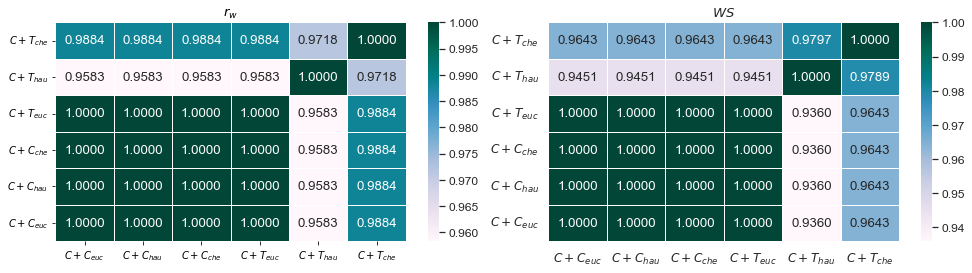

In [14]:
plt.figure(figsize = (14,4))
plt.subplot(1, 2, 1)
draw_heatmap(df_new_heatmap_rw, r'$r_w$')
plt.subplot(1, 2, 2)
draw_heatmap(df_new_heatmap_ws, r'$WS$')
plt.show()

Visualization of voivodeship rankings provided by each applied MCDA approach for the analysed year

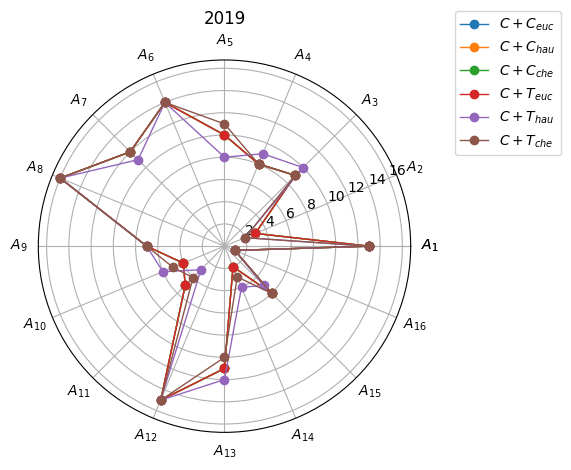

In [15]:
# radar plot
matplotlib.rc_file_defaults()

fig=plt.figure()
ax = fig.add_subplot(111, polar=True)

for col in list(df_writer_rank.columns):
    labels=np.array(list(df_writer_rank.index))
    stats = df_writer_rank.loc[labels, col].values

    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    
    list_of_indexes = list(df_writer_rank.index)
    list_of_indexes.append(df_writer_rank.index[0])
    labels=np.array(list_of_indexes)

    ax.plot(angles, stats, 'o-', linewidth=1)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)
ax.set_axisbelow(True)
plt.legend(df_writer_rank.columns, bbox_to_anchor=(1.1, 0.95, 0.3, 0.2), loc='upper left')
plt.title(str(year))
plt.tight_layout()
plt.show()